<a href="https://colab.research.google.com/github/fcolombo7/AN2DL-2020/blob/main/Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploration of the dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from zipfile import ZipFile
import sys
sys.path.append('/content/drive/MyDrive/ANN_project2/starting_kit')

from prepare_submission import *
from read_mask_example import * 
from decode_rle_example import *

import tensorflow as tf
import numpy as np

In [3]:
# Set the seed for random operations. 
SEED = 1234
tf.random.set_seed(SEED)

In [4]:
#Definitions of constants
apply_data_augmentation = True
IMG_H, IMG_W = 256, 256

## Load the dataset

In [5]:
if not os.path.exists('Development_Dataset'):
  with ZipFile('./drive/MyDrive/ANN_project2/dataset.zip', 'r') as zipObj:
    # Extract all the contents of zip file in current directory
    zipObj.extractall()
print('The dataset is loaded.')

The dataset is loaded.


Check properties of the images such as the number of training samples and the shapes.

In [6]:
cwd = os.getcwd()

In [7]:
import pathlib
path = os.path.join(cwd, 'Development_Dataset', 'Training', 'Bipbip') 
data_dir = pathlib.Path(path)
training_images_h = list(data_dir.glob('Haricot/Images/*'))
training_images_m = list(data_dir.glob('Mais/Images/*')) 
training_masks_h = list(data_dir.glob('Haricot/Masks/*'))
training_masks_m = list(data_dir.glob('Haricot/Masks/*'))

print(f"number of haricot images: {len(training_images_h)}")
print(f"number of mais images: {len(training_images_m)}")

number of haricot images: 90
number of mais images: 90


In [8]:
import PIL

image_sizes = set() #unique sizes
for image in training_images_h+training_images_m:
  image_sizes.add(PIL.Image.open(str(image)).size)
print(f"number of unique sizes: {len(image_sizes)}")

number of unique sizes: 1


In [9]:
print(f'input shape: {PIL.Image.open(str(training_images_h[0])).size}')

input shape: (2048, 1536)


Define the `ImageDataGenerator`

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')

In [11]:
from PIL import Image
from sklearn.model_selection import train_test_split

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, dataset_dir_list, which_subset, seed=1234, valid_perc=0.2, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[256, 256]):
    
    self.subset_filenames=[]
    for dataset_dir in dataset_dir_list:
      #get all the filenames
      path = dataset_dir
      #single filename list
      l = os.listdir(os.path.join(path, 'Images'))
      l = list(map(lambda x: x[:-4], l))
      #print(l)
      #get the train test split
      pos_train, pos_valid = train_test_split(range(len(l)), test_size = valid_perc, random_state=seed)
      sel_pos= pos_train if which_subset == 'training' else pos_valid
      for pos in sel_pos:
        self.subset_filenames.append((dataset_dir, l[pos]))

    self.which_subset = which_subset
    self.dataset_dir_list = dataset_dir_list
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    img = Image.open(os.path.join(curr_filename[0], 'Images', curr_filename[1] + '.jpg'))
    #mask = Image.open(os.path.join(curr_filename[0], 'Masks', curr_filename[1] + '.png'))
    

    # Resize image and mask
    img = img.resize(self.out_shape)
    #mask = mask.resize(self.out_shape, resample=Image.NEAREST)
    mask_arr = read_rgb_mask(os.path.join(curr_filename[0], 'Masks', curr_filename[1] + '.png'), out_shape=self.out_shape)
    
    img_arr = np.array(img)
    #mask_arr = np.array(mask)

    # in this dataset 255 mask label is assigned to an additional class, which corresponds 
    # to the contours of the objects. We remove it for simplicity.
    #mask_arr[mask_arr == 255] = 0  

    mask_arr = np.expand_dims(mask_arr, -1)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [12]:
from tensorflow.keras.applications.vgg16 import preprocess_input 
dir1 = os.path.join(cwd, 'Development_Dataset', 'Training', 'Bipbip', 'Haricot')
dir2 = os.path.join(cwd, 'Development_Dataset', 'Training', 'Bipbip', 'Mais')


dataset = CustomDataset([dir1, dir2], 
                        'training',
                        seed = SEED,
                        valid_perc=0.2,
                        img_generator=img_data_gen,
                        mask_generator=mask_data_gen,
                        out_shape=[IMG_H, IMG_W],
                        preprocessing_function=preprocess_input)

In [13]:
train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([IMG_H, IMG_W, 3], [IMG_H, IMG_W, 1]))

train_dataset = train_dataset.batch(32)

train_dataset = train_dataset.repeat()

In [14]:
# Let's test data generator
# -------------------------
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 20)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(train_dataset)

[0. 1. 2.]


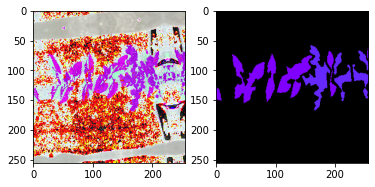

In [15]:
fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   # First element
augmented_img = augmented_img  # denormalize

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 21):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()